In [17]:
# """
# predicting a sequence of future prices (`n_steps_out`) instead of just one.

# Benefits of This Approach
# Utilizes Temporal Patterns: The model learns dependencies across multiple future time steps.
# More Robust Predictions: Predicting a sequence captures trends better than single-step predictions.
# Real-World Applicability: Multi-step forecasting is closer to real-world use cases, such as portfolio management.
# """

time: 314 µs (started: 2024-11-24 14:08:55 +00:00)


In [7]:
# !pip install -r requirements.txt -q
# !pip install ipython-autotime -q
!pip install pydot -q
!sudo apt install graphviz -y
# !pip install tensorflow-addons -q

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-liberation libann0 libcdt5 libcgraph6 libgts-0.7-5 libgts-bin libgvc6
  libgvpr2 liblab-gamut1 libpathplan4
Suggested packages:
  gsfonts graphviz-doc
The following NEW packages will be installed:
  fonts-liberation graphviz libann0 libcdt5 libcgraph6 libgts-0.7-5 libgts-bin
  libgvc6 libgvpr2 liblab-gamut1 libpathplan4
0 upgraded, 11 newly installed, 0 to remove and 100 not upgraded.
Need to get 4678 kB of archives.
After this operation, 10.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-liberation all 1:1.07.4-11 [822 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libann0 amd64 1.1.2+doc-7build1 [26.0 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libcdt5 amd64 2.42.2-6 [21.1 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import math
import matplotlib.pyplot as plt
import joblib
from joblib import Parallel, delayed
from pathlib import Path

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.layers import Input, Dense, Dropout, BatchNormalization, Reshape, Flatten, Bidirectional, LSTM
from keras.models import Model, Sequential
from keras.optimizers import Adam

%matplotlib inline
%load_ext autotime

print("tensorflow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.test.is_built_with_cuda()

2024-11-25 03:29:55.138302: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-25 03:29:55.138350: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-25 03:29:55.174612: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-25 03:29:55.185024: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-25 03:29:55.992943: W tensorflow/compiler/tf2

tensorflow version: 2.15.0
Num GPUs Available:  1


2024-11-25 03:29:57.742163: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-25 03:29:57.903260: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-25 03:29:57.903446: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

True

time: 191 ms (started: 2024-11-25 03:29:57 +00:00)


In [3]:
# parameter
# n_steps_in: Number of input time steps
# n_steps_out: Number of days to predict ahead

n_steps_in = 14
n_steps_out = 5
epochs = 200
batch_size = 64

time: 516 µs (started: 2024-11-25 03:29:57 +00:00)


In [4]:
def load_processed_data(data_dir='processed_data', df_name='', array_name=''):
    """
    Load processed DataFrames list and numpy arrays from files
    """
    data_path = Path(data_dir)
    
    # Load list of DataFrames
    with open(data_path / df_name, 'rb') as f:
        processed_dfs = joblib.load(f)
    
    # Load numpy arrays
    with open(data_path / array_name, 'rb') as f:
        values_list = joblib.load(f)
    
    return processed_dfs, values_list

processed_dfs, values_list = load_processed_data(df_name='processed_dfs.pkl', array_name='values_array.pkl')

time: 289 ms (started: 2024-11-25 03:29:57 +00:00)


In [5]:
for i in range(len(processed_dfs)):
    # processed_dfs[i].drop(processed_dfs[i].columns[1:5], axis=1, inplace=True)
    processed_dfs[i].drop(columns=['RSI', 'WR','Price Momentum', 'Volume Momentum', 'EMA7', 'CCI', 'Ulcer Index'],inplace=True)
processed_dfs[0]

/tmp/ipykernel_40/3160250006.py:3: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  processed_dfs[i].drop(columns=['RSI', 'WR','Price Momentum', 'Volume Momentum', 'EMA7', 'CCI', 'Ulcer Index'],inplace=True)


Price,Adj Close,Close,High,Low,Open,Volume,SD20,SMA7,SMA14,SMA21,...,Lower Band,ARIMA Output,Fourier Power,Fourier Phase,Fourier 3 Real,Fourier 6 Real,Fourier 9 Real,Fourier 100 Real,Fourier Significant real,Close Next Day
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,...,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,
2011-08-16,11.462601,13.588571,13.691786,13.430714,13.625714,1000000.0,0.441967,13.293316,13.563801,13.700425,...,12.850948,11.386598,564.736488,1.784183,50.608489,10.548855,-3.418024,12.356305,16.000357,13.587143
2011-08-17,11.461396,13.587143,13.732857,13.500000,13.653929,1000000.0,0.442083,13.432245,13.534770,13.706531,...,12.839185,11.624125,497.700387,1.823144,50.372918,10.291735,-3.410067,12.751208,15.711276,13.073214
2011-08-18,11.027875,13.073214,13.308929,12.906071,13.244286,1000000.0,0.462345,13.391633,13.472449,13.671071,...,12.761759,11.368409,645.802434,1.591148,50.137814,10.037805,-3.396865,13.168186,15.424764,12.715357
2011-08-19,10.726002,12.715357,13.107143,12.714286,12.934643,1000000.0,0.498631,13.352551,13.368571,13.617908,...,12.624472,11.025292,707.291371,1.742971,49.903177,9.787063,-3.378466,13.593889,15.140825,12.730000
2011-08-22,10.738355,12.730000,13.031429,12.681786,13.018214,1000000.0,0.510826,13.264490,13.285740,13.555221,...,12.525591,10.494964,569.391019,1.997446,49.669010,9.539509,-3.354922,14.014846,14.859461,13.342857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-24,230.316620,230.570007,230.820007,228.410004,229.979996,1000000.0,3.892879,233.228570,230.810000,229.767143,...,222.290882,230.674707,21857.804244,-1.509946,105.115706,115.104123,117.980892,188.509112,114.330593,231.410004
2024-10-25,231.155685,231.410004,233.220001,229.570007,229.740005,1000000.0,3.874728,233.175714,231.504286,229.952381,...,222.507266,231.297362,30163.314500,-1.569032,104.839212,114.481354,117.032685,177.737174,113.773702,233.399994


time: 36.5 ms (started: 2024-11-25 03:29:58 +00:00)


In [6]:
def preprocess_stock_data(values_list, n_steps_in=14, n_steps_out=5, train_split=0.8):
    """
    Preprocess multiple stock datasets for LSTM training.
    
    Args:
        values_list: List of numpy arrays containing stock data with technical indicators
        n_steps_in: Number of lookback days
        n_steps_out: Number of prediction days
        train_split: Train/validation split ratio
        
    Returns:
        tuple: (train_X, train_y, val_X, val_y, global_scaler)
    """
    # 1. Global scaling across all stocks
    global_scaler = MinMaxScaler(feature_range=(0, 1))
    combined_values = np.vstack(values_list)
    scaled_combined = global_scaler.fit_transform(combined_values)
    
    # 2. Split back into individual stocks
    scaled_values_list = []
    start_idx = 0
    for values in values_list:
        scaled_values_list.append(scaled_combined[start_idx:start_idx + len(values)])
        start_idx += len(values)
    
    # 3. Create sequences for each stock
    train_X_list, train_y_list = [], []
    val_X_list, val_y_list = [], []
    
    for scaled_values in scaled_values_list:
        # Remove 'Close Next Day' from features (last column)
        features = scaled_values[:, :-1]  # All columns except the last one
        targets = scaled_values[:, -1]    # Only the last column
        
        # Split into train/validation
        n_train = int(len(features) * train_split)
        
        # Ensure we have enough data for both training and validation
        if n_train <= n_steps_in + n_steps_out:
            print(f"Warning: Stock with {len(features)} samples is too short for meaningful splitting")
            continue
            
        # Split features and targets
        train_features = features[:n_train]
        train_targets = targets[:n_train]
        val_features = features[n_train:]
        val_targets = targets[n_train:]
        
        # Create sequences
        if len(train_features) > n_steps_in + n_steps_out:
            train_X, train_y = create_sequences(train_features, train_targets, n_steps_in, n_steps_out)
            train_X_list.append(train_X)
            train_y_list.append(train_y)
            
        if len(val_features) > n_steps_in + n_steps_out:
            val_X, val_y = create_sequences(val_features, val_targets, n_steps_in, n_steps_out)
            val_X_list.append(val_X)
            val_y_list.append(val_y)
    
    # 4. Combine all sequences
    train_X = np.vstack(train_X_list)
    train_y = np.vstack(train_y_list)
    val_X = np.vstack(val_X_list)
    val_y = np.vstack(val_y_list)
    
    print(f"Training shapes: X={train_X.shape}, y={train_y.shape}")
    print(f"Validation shapes: X={val_X.shape}, y={val_y.shape}")
    print(f"Number of features: {train_X.shape[2]}")
    
    return train_X, train_y, val_X, val_y, global_scaler

def create_sequences(features, targets, n_steps_in, n_steps_out):
    """
    Generate synchronized sequences for LSTM input features and output targets.
    
    Args:
        features: Scaled feature data (numpy array)
        targets: Scaled target data (numpy array)
        n_steps_in: Number of input time steps
        n_steps_out: Number of output time steps
        
    Returns:
        tuple: (X sequences, y sequences)
    """
    X, y = [], []
    
    # Ensure we have enough data for sequence creation
    if len(features) < n_steps_in + n_steps_out:
        raise ValueError("Data length is too short for the specified sequence lengths")
    
    for i in range(len(features) - n_steps_in - n_steps_out + 1):
        # Input sequence (n_steps_in days of all features)
        seq_x = features[i:(i + n_steps_in)]
        # Output sequence (next n_steps_out days of target variable)
        seq_y = targets[(i + n_steps_in):(i + n_steps_in + n_steps_out)]
        
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

train_X, train_y, val_X, val_y, scaler = preprocess_stock_data(values_list, n_steps_in, n_steps_out, train_split=0.8)

Training shapes: X=(66115, 14, 32), y=(66115, 5)
Validation shapes: X=(16184, 14, 32), y=(16184, 5)
Number of features: 32
time: 352 ms (started: 2024-11-25 03:29:58 +00:00)


# training

In [24]:
# import tensorflow_addons as tfa

# Cyclical learning rate
# steps_per_epoch = len(train_X) // batch_size
# n = 2
# cycle = 12
# epochs = cycle * n * 2
# print(epochs)

# clr = tfa.optimizers.TriangularCyclicalLearningRate(
#     initial_learning_rate=1e-4,
#     maximal_learning_rate=1e-2,
#     step_size = n * steps_per_epoch)

# def lstm_model(n_steps_in, n_features, n_steps_out):
#     tf.keras.backend.clear_session()
#     model = Sequential([
#         LSTM(250, activation='leaky_relu', dropout=0.025, input_shape=(n_steps_in, n_features)),
#         Dense(n_steps_out)
#     ])
    
#     optimizer = tf.keras.optimizers.Adam(1e-4)
#     loss = ['mae']
#     model.compile(optimizer=optimizer, loss_weights=[1], loss=loss)
#     model.summary()
    
#     return model

# # Create and train model
# model = lstm_model(n_steps_in=n_steps_in, n_features=train_X.shape[2], n_steps_out=n_steps_out)

time: 372 µs (started: 2024-11-24 14:08:59 +00:00)


In [25]:
from tensorflow.keras.layers import Input, LSTM, Dense, MultiHeadAttention

def lstm_multihead_attention(n_steps_in, n_features, n_steps_out):
    tf.keras.backend.clear_session()

    # Input layer
    inputs = Input(shape=(n_steps_in, n_features))

    # LSTM Layer
    lstm_output = LSTM(250, activation='leaky_relu', dropout=0.025, return_sequences=True)(inputs)

    # Multi-Head Attention Layer
    attention_output = MultiHeadAttention(num_heads=4, key_dim=64)(lstm_output, lstm_output)

    # Flatten or pooling if needed
    attention_output = Dense(128, activation='relu')(attention_output)

    # Dense output layer
    outputs = Dense(n_steps_out)(attention_output)

    # Create model
    model = tf.keras.models.Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='mae')
    model.summary()

    return model

model = lstm_multihead_attention(n_steps_in=n_steps_in, n_features=train_X.shape[2], n_steps_out=n_steps_out)

time: 880 µs (started: 2024-11-24 14:08:59 +00:00)


In [26]:
from tensorflow.keras.layers import Input, LSTM, Dense, Attention, LayerNormalization, Concatenate, Flatten

def lstm_attention(n_steps_in, n_features, n_steps_out):
    tf.keras.backend.clear_session()

    inputs = Input(shape=(n_steps_in, n_features))
    lstm_output = LSTM(100, activation='relu', dropout=0.025, return_sequences=True)(inputs)
    lstm_output = LayerNormalization()(lstm_output)

    # Attention Layer
    query = Dense(64, name='query')(lstm_output)
    value = Dense(64, name='value')(lstm_output)
    attention_output = Attention()([query, value])
    
    # Combine attention output with LSTM output
    combined = Concatenate()([lstm_output, attention_output])

    # Dense layers for processing the combined output
    dense1 = Dense(64, activation='relu', name='dense_1')(combined)
    dense2 = Dense(32, activation='relu', name='dense_2')(dense1)
    
    # Final output layer
    # Reshape the output to match n_steps_out
    # First, flatten the temporal dimension
    flattened = Flatten()(dense2)
    # Then project to the desired output shape
    outputs = Dense(n_steps_out, name='output')(flattened)

    # Create model
    model = tf.keras.models.Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='mae')
    model.summary()

    return model

# model = lstm_attention(n_steps_in=n_steps_in, n_features=train_X.shape[2], n_steps_out=n_steps_out)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 90, 32)]             0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 90, 100)              53200     ['input_1[0][0]']             
                                                                                                  
 layer_normalization (Layer  (None, 90, 100)              200       ['lstm[0][0]']                
 Normalization)                                                                                   
                                                                                                  
 query (Dense)               (None, 90, 64)               6464      ['layer_normalization[0][0

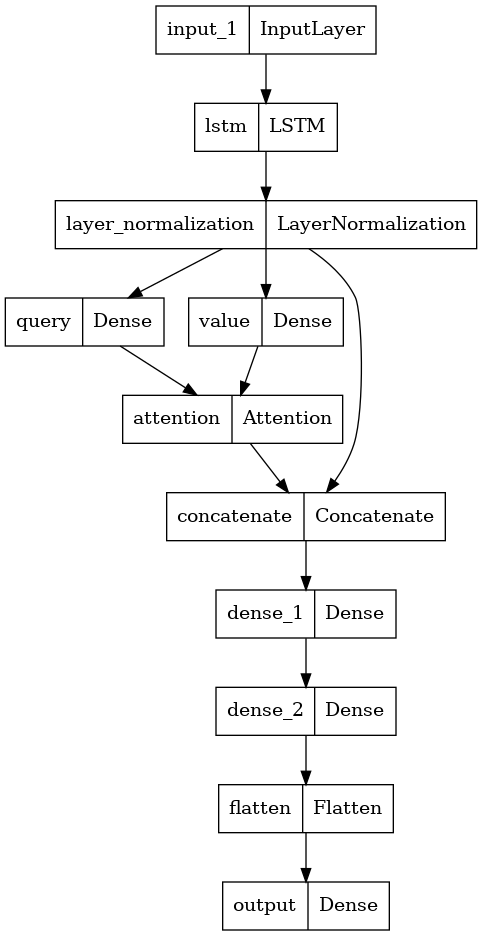

time: 51.2 ms (started: 2024-11-24 14:08:59 +00:00)


In [27]:
tf.keras.utils.plot_model(model)

In [28]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    mode='min',
    restore_best_weights=True
)

history = model.fit(
    train_X,
    train_y,
    validation_data=(val_X, val_y),
    epochs=epochs,
    batch_size=64,
    verbose=2,
    shuffle=False,
    callbacks=[early_stopping],
)

model.save('./model/lstm_model.keras')

Epoch 1/200
988/988 - 69s - loss: 0.0436 - val_loss: 0.1171 - 69s/epoch - 70ms/step
Epoch 2/200
988/988 - 68s - loss: 0.0317 - val_loss: 0.0296 - 68s/epoch - 69ms/step
Epoch 3/200
988/988 - 67s - loss: 0.0274 - val_loss: 0.0402 - 67s/epoch - 68ms/step
Epoch 4/200
988/988 - 67s - loss: 0.0237 - val_loss: 0.0367 - 67s/epoch - 68ms/step
Epoch 5/200
988/988 - 70s - loss: 0.0235 - val_loss: 0.0407 - 70s/epoch - 71ms/step
Epoch 6/200
988/988 - 68s - loss: 0.0226 - val_loss: 0.0474 - 68s/epoch - 69ms/step
Epoch 7/200
988/988 - 69s - loss: 0.0218 - val_loss: 0.0443 - 69s/epoch - 70ms/step
Epoch 8/200
988/988 - 67s - loss: 0.0205 - val_loss: 0.0552 - 67s/epoch - 68ms/step
Epoch 9/200
988/988 - 67s - loss: 0.0191 - val_loss: 0.0296 - 67s/epoch - 67ms/step
Epoch 10/200
988/988 - 67s - loss: 0.0222 - val_loss: 0.0378 - 67s/epoch - 68ms/step
Epoch 11/200
988/988 - 68s - loss: 0.0186 - val_loss: 0.0532 - 68s/epoch - 69ms/step
Epoch 12/200
988/988 - 69s - loss: 0.0187 - val_loss: 0.0462 - 69s/epoch -

In [29]:
model = tf.keras.models.load_model('./model/lstm_model.keras')

time: 269 ms (started: 2024-11-24 14:28:18 +00:00)


In [30]:
print(f"min val loss:", min(history.history['val_loss']) )
# Make predictions
y_pred = model.predict(val_X)
print(y_pred.shape)
# Evaluate for each time step
for i in range(n_steps_out):
    mae = mean_absolute_error(val_y[:, i], y_pred[:, i])
    print(f"MAE for step {i+1}: {mae: .4f}")

min val loss: 0.029564430937170982
416/416 [==============================] - 5s 13ms/step
(13298, 40)
MAE for step 1:  0.0292
MAE for step 2:  0.0320
MAE for step 3:  0.0271
MAE for step 4:  0.0316
MAE for step 5:  0.0278
MAE for step 6:  0.0228
MAE for step 7:  0.0278
MAE for step 8:  0.0294
MAE for step 9:  0.0292
MAE for step 10:  0.0313
MAE for step 11:  0.0333
MAE for step 12:  0.0255
MAE for step 13:  0.0355
MAE for step 14:  0.0301
MAE for step 15:  0.0351
MAE for step 16:  0.0290
MAE for step 17:  0.0257
MAE for step 18:  0.0279
MAE for step 19:  0.0289
MAE for step 20:  0.0256
MAE for step 21:  0.0285
MAE for step 22:  0.0282
MAE for step 23:  0.0286
MAE for step 24:  0.0264
MAE for step 25:  0.0293
MAE for step 26:  0.0282
MAE for step 27:  0.0305
MAE for step 28:  0.0278
MAE for step 29:  0.0304
MAE for step 30:  0.0298
MAE for step 31:  0.0281
MAE for step 32:  0.0330
MAE for step 33:  0.0294
MAE for step 34:  0.0305
MAE for step 35:  0.0311
MAE for step 36:  0.0289
MAE fo

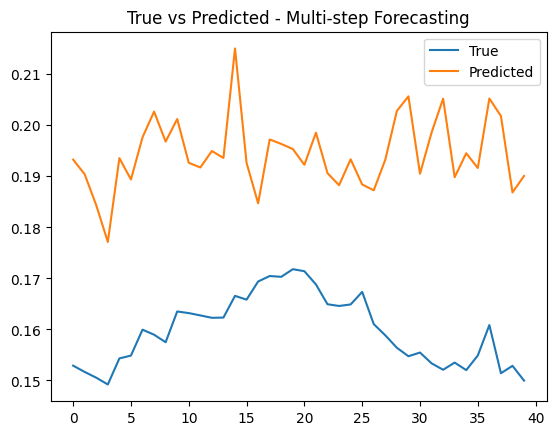

time: 118 ms (started: 2024-11-24 14:28:25 +00:00)


In [31]:
plt.plot(val_y[0], label='True')
plt.plot(y_pred[0], label='Predicted')
plt.legend()
plt.title('True vs Predicted - Multi-step Forecasting')
plt.show()

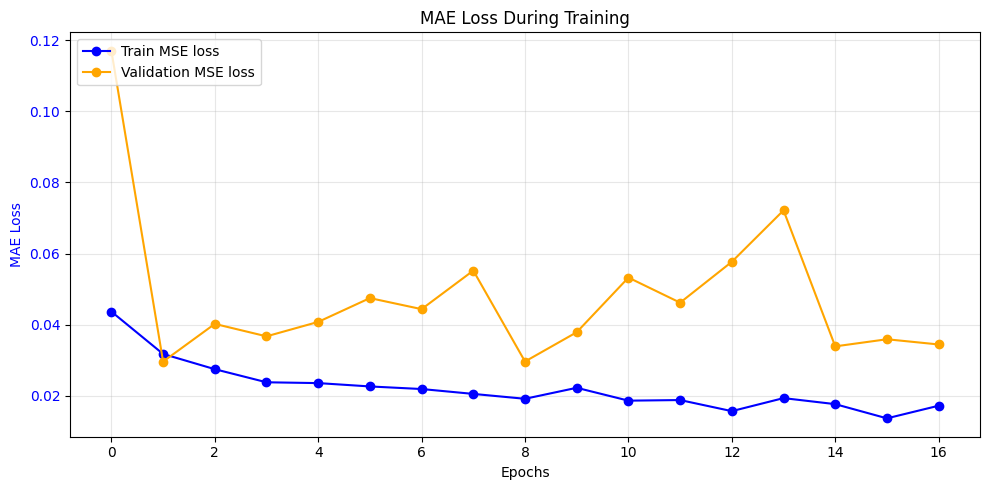

time: 139 ms (started: 2024-11-24 14:28:25 +00:00)


In [32]:
# Plotting
fig1, ax1 = plt.subplots(figsize=(10, 5))

# Loss plot
N = len(history.history["loss"])
epoch_range = np.arange(0, N)

ax1.plot(epoch_range, history.history["loss"], label='Train MSE loss', marker='o', color='blue')
ax1.plot(epoch_range, history.history["val_loss"], label='Validation MSE loss', marker='o', color='orange')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MAE Loss', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')
plt.grid(True, alpha=0.3)
ax1.set_title('MAE Loss During Training')

# RMSE plot (shared x-axis, different y-axis)
# ax2 = ax1.twinx()
# fig2, ax2 = plt.subplots(figsize=(10, 5))
# ax2.plot(epoch_range, history.history["unscaled_mse"], label='Train MSE', color='green')
# ax2.plot(epoch_range, history.history["val_unscaled_mse"], label='Validation MSE', color='red')
# ax2.set_xlabel('Epochs')
# ax2.set_ylabel('Root Mean Squared Error (RMSE)', color='green')
# ax2.tick_params(axis='y', labelcolor='green')
# ax2.legend(loc='upper left')
# plt.grid(True, alpha=0.3)
# ax2.set_title('RMSE During Training')

plt.tight_layout()
plt.show()


Analyzing AAPL...

Evaluation Metrics for AAPL:
MSE: 1138.6789
RMSE: 33.7443
MAE: 29.8310


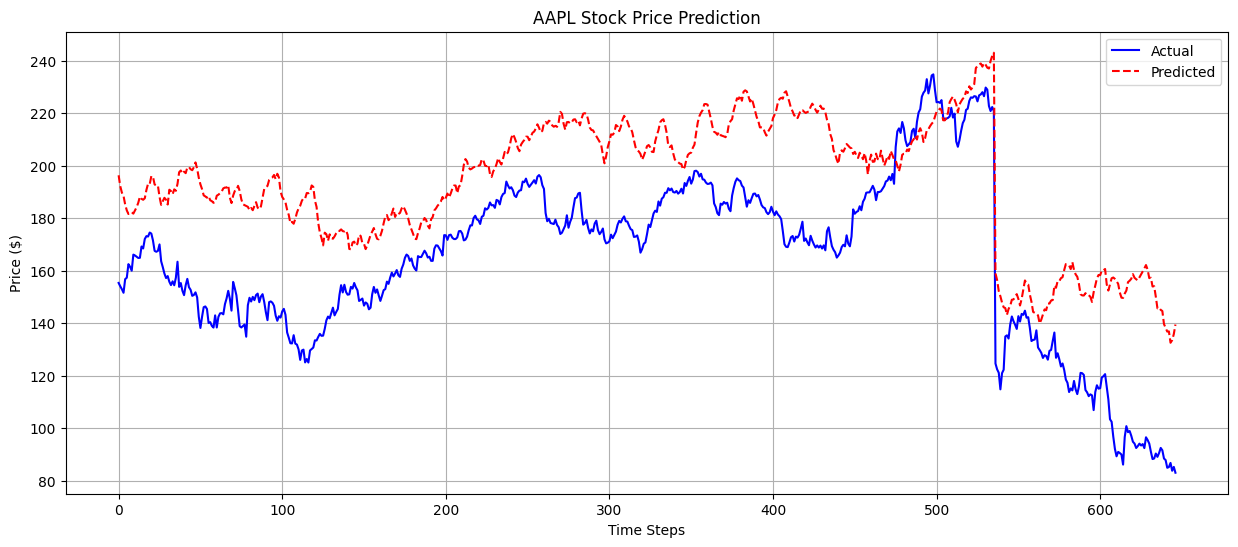


Analyzing AMZN...

Evaluation Metrics for AMZN:
MSE: 469.1601
RMSE: 21.6601
MAE: 16.7491


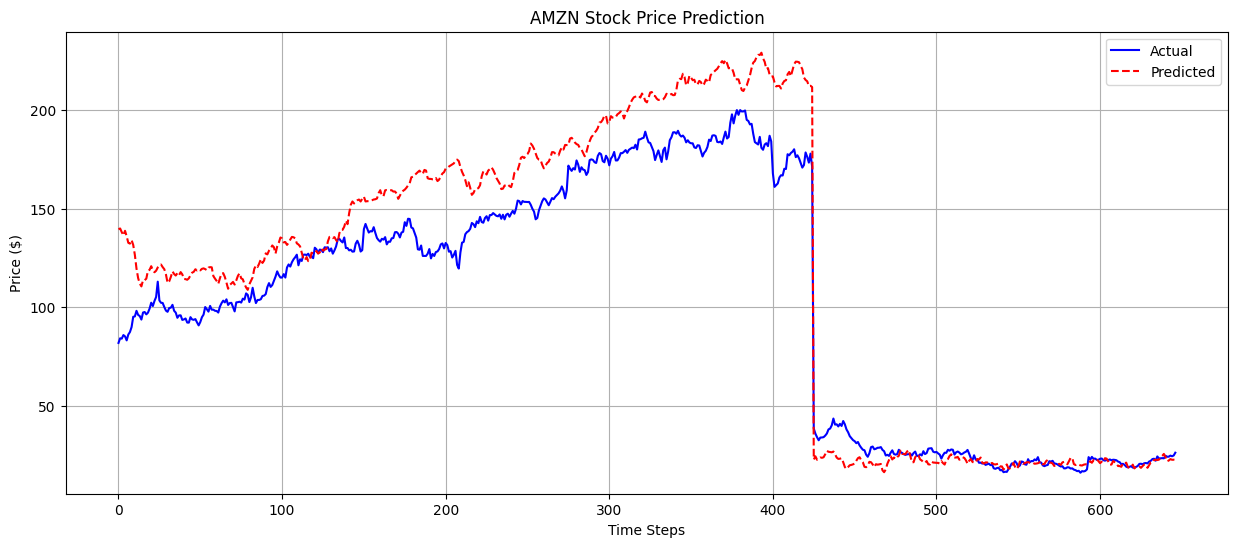


Analyzing GME...

Evaluation Metrics for GME:
MSE: 541.5705
RMSE: 23.2717
MAE: 17.4741


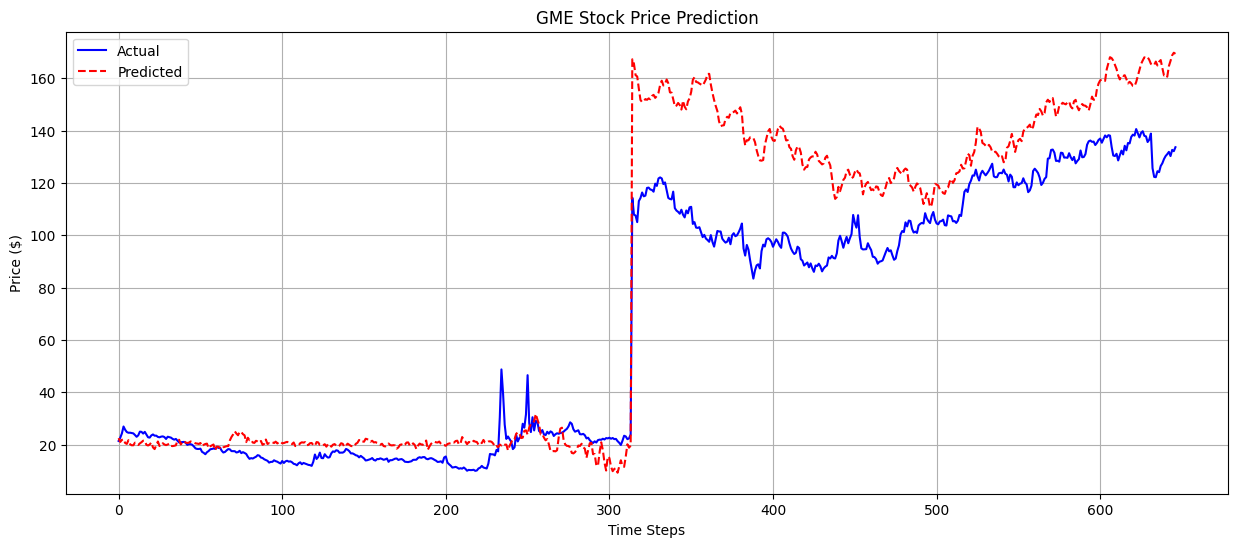


Analyzing GOOGL...

Evaluation Metrics for GOOGL:
MSE: 1771.0943
RMSE: 42.0844
MAE: 35.1057


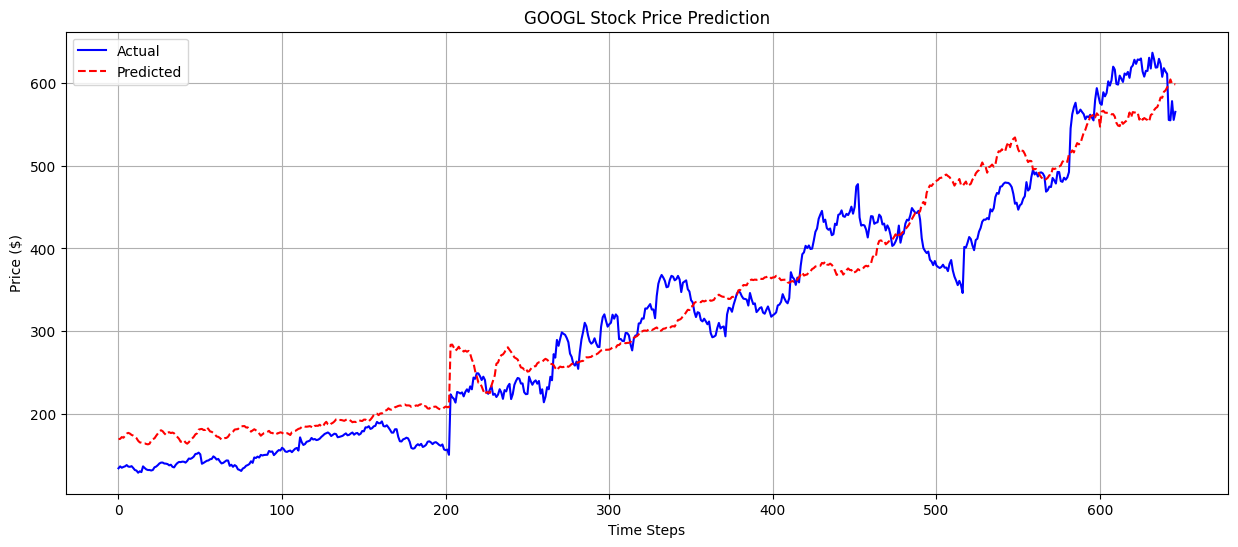


Analyzing NFLX...

Evaluation Metrics for NFLX:
MSE: 2114.4688
RMSE: 45.9834
MAE: 37.4727


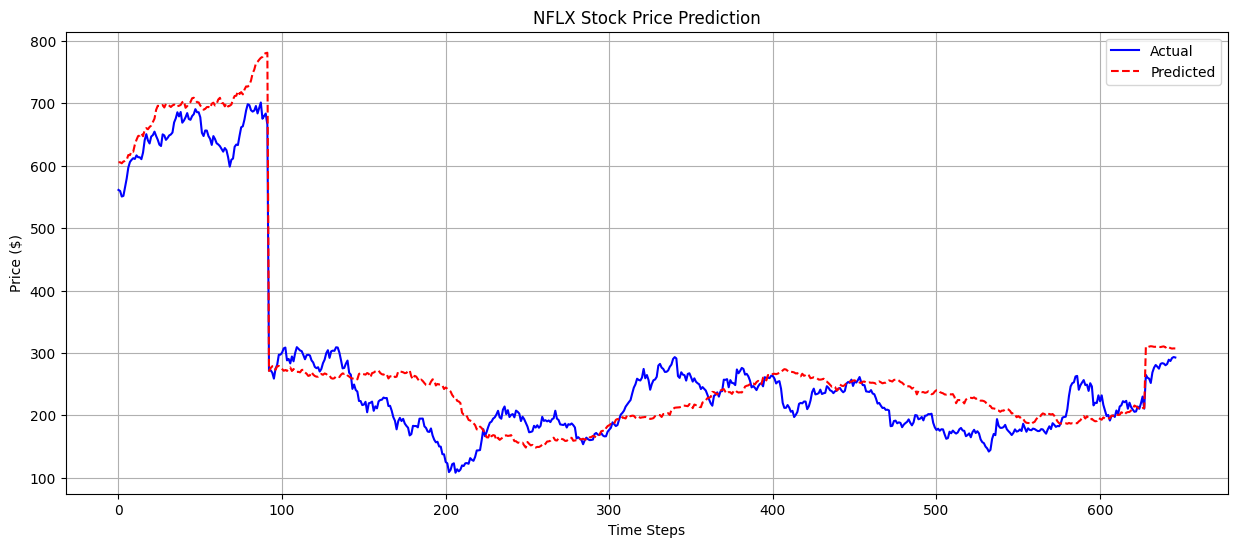


Analyzing TSLA...

Evaluation Metrics for TSLA:
MSE: 800.0432
RMSE: 28.2850
MAE: 23.7298


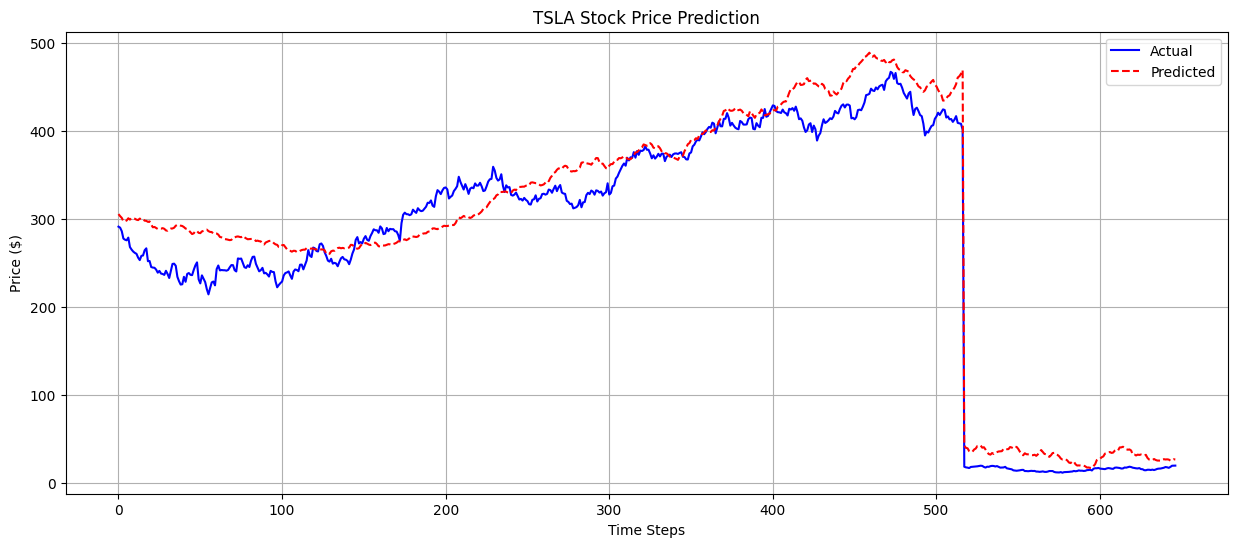


Analyzing MSFT...

Evaluation Metrics for MSFT:
MSE: 256.6156
RMSE: 16.0192
MAE: 12.4021


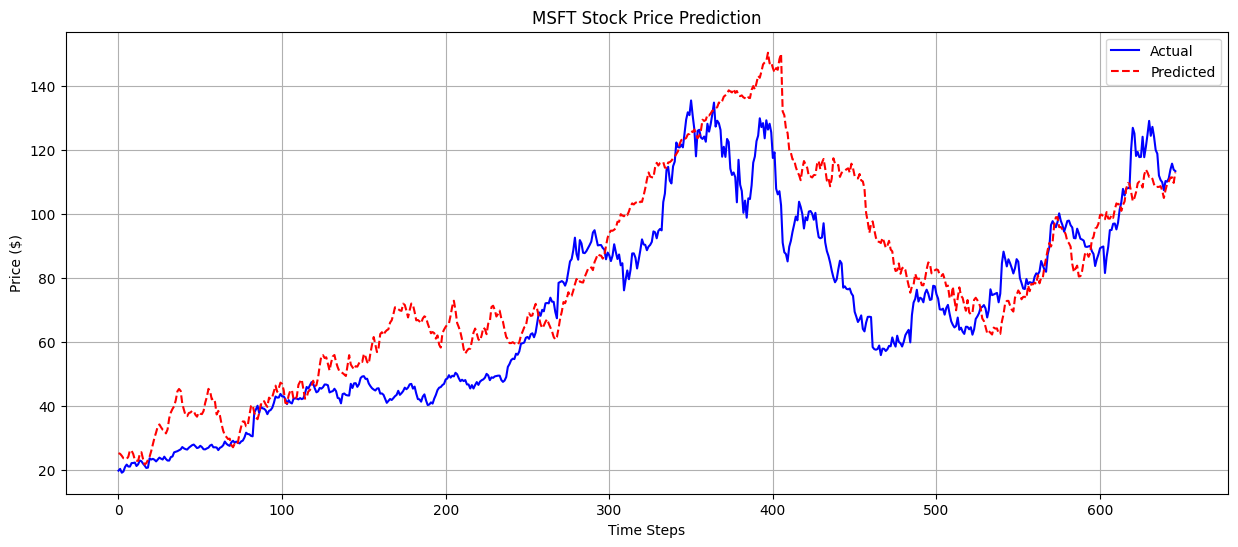


Analyzing NVDA...

Evaluation Metrics for NVDA:
MSE: 684.7060
RMSE: 26.1669
MAE: 21.3615


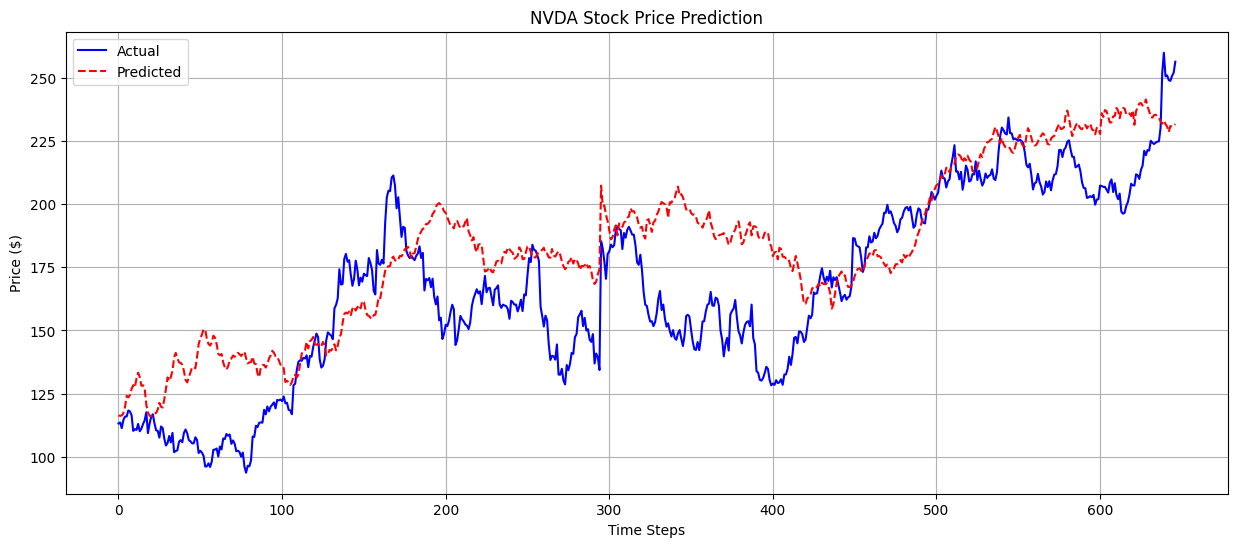


Analyzing AMD...

Evaluation Metrics for AMD:
MSE: 953.1037
RMSE: 30.8724
MAE: 28.3351


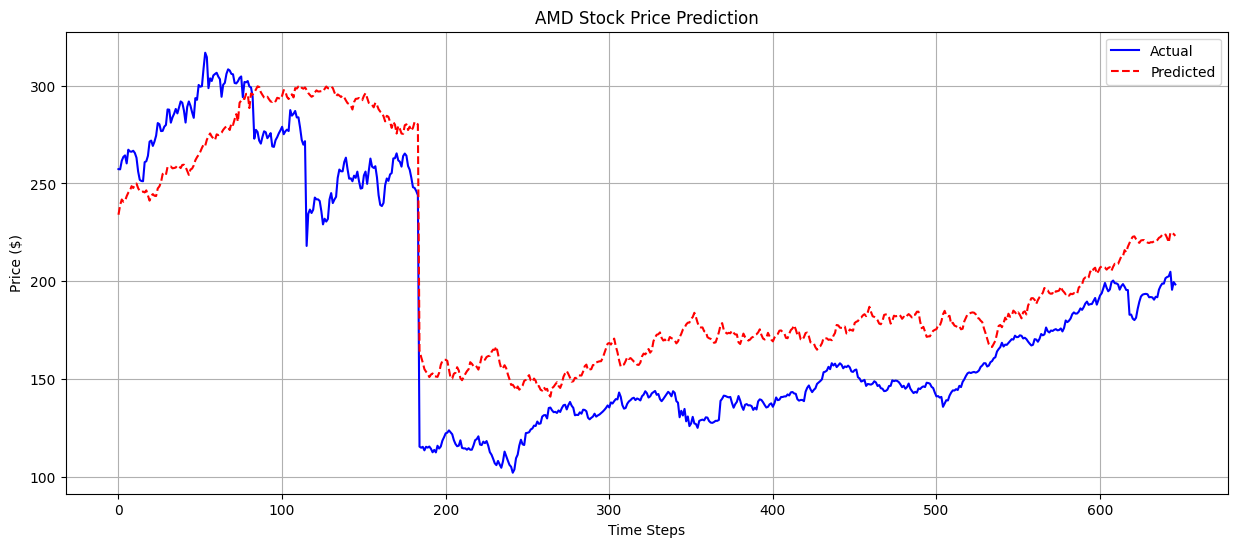


Analyzing CRM...

Evaluation Metrics for CRM:
MSE: 820.3399
RMSE: 28.6416
MAE: 24.1791


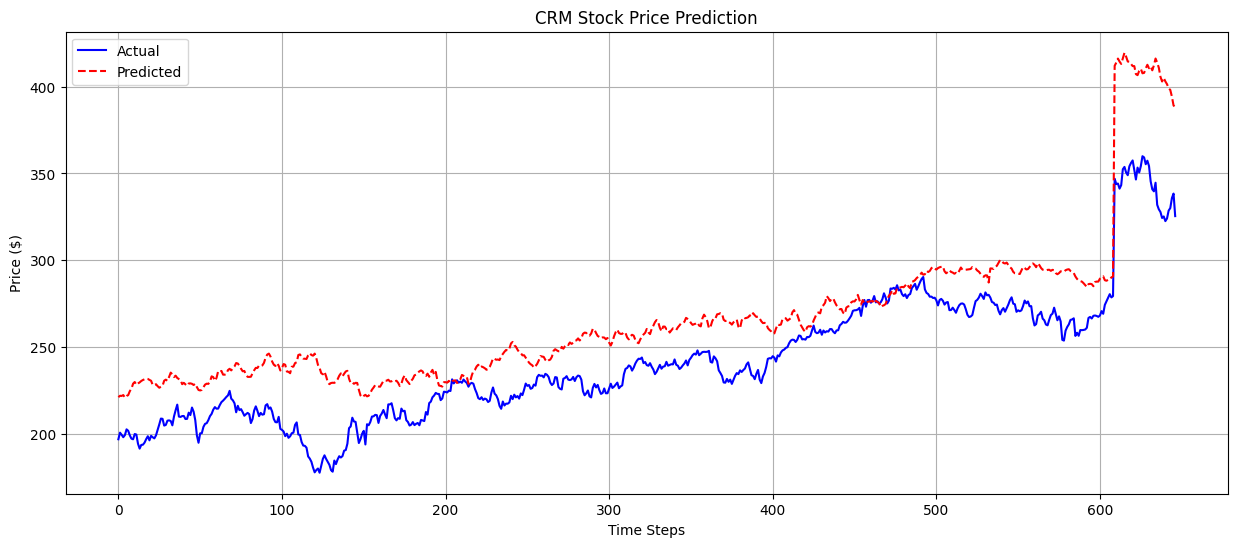


Analyzing JPM...

Evaluation Metrics for JPM:
MSE: 2879.9269
RMSE: 53.6650
MAE: 45.9698


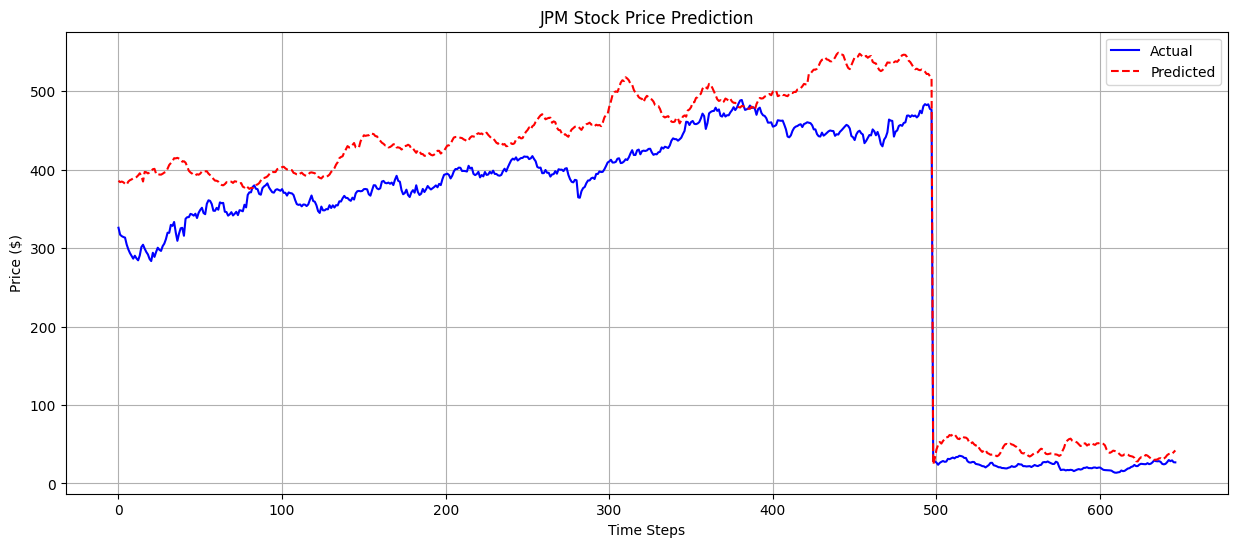


Analyzing V...

Evaluation Metrics for V:
MSE: 452.5256
RMSE: 21.2726
MAE: 14.5486


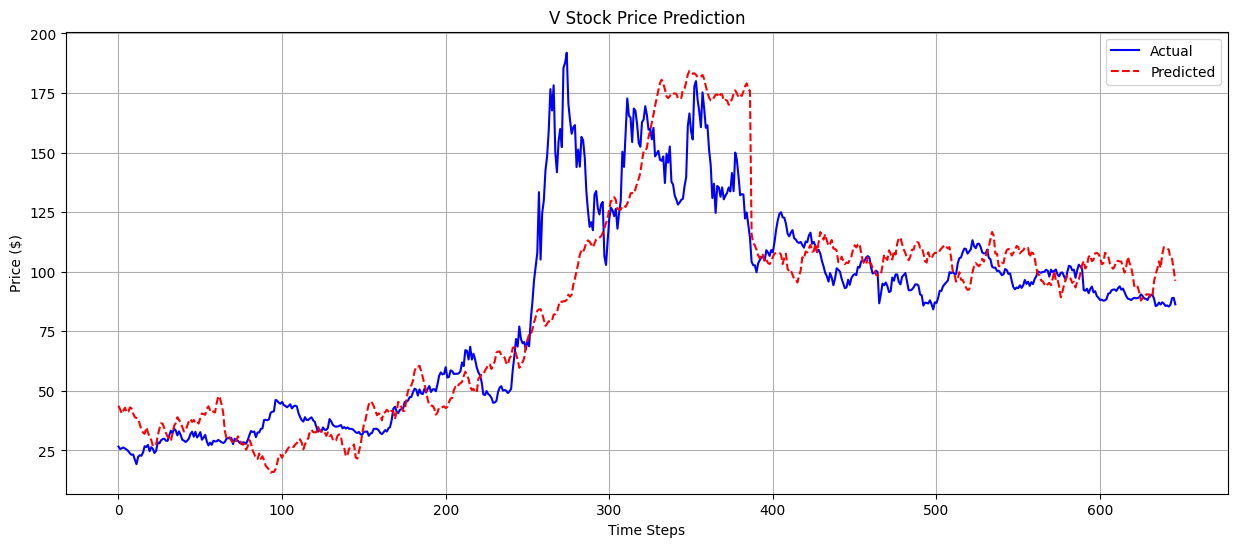


Analyzing MA...

Evaluation Metrics for MA:
MSE: 539.6504
RMSE: 23.2304
MAE: 17.6256


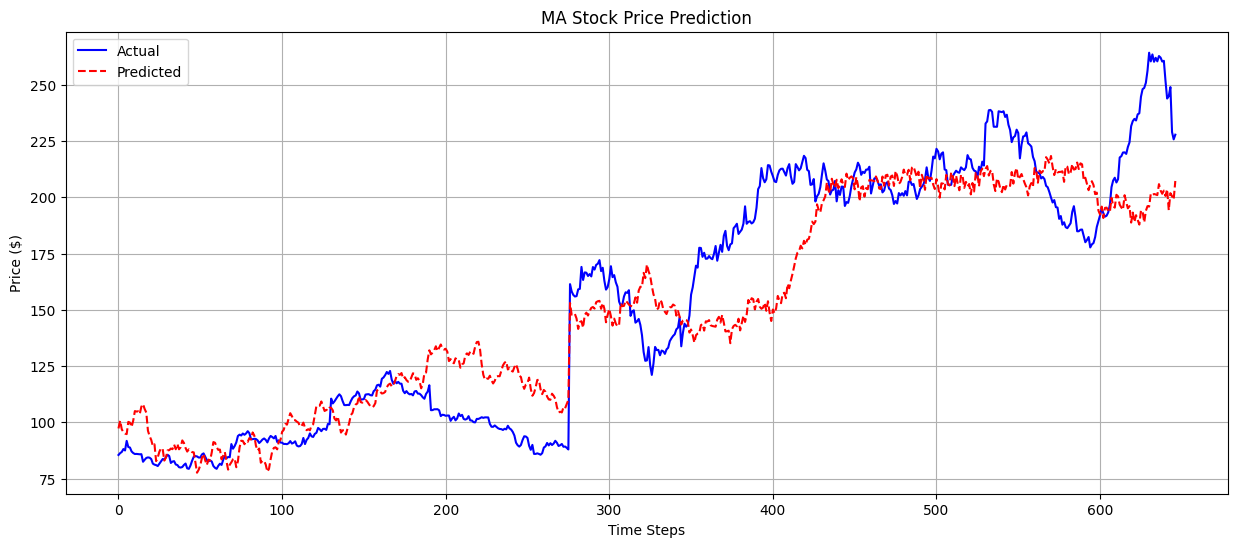


Analyzing MSTR...

Evaluation Metrics for MSTR:
MSE: 227.5421
RMSE: 15.0845
MAE: 12.1921


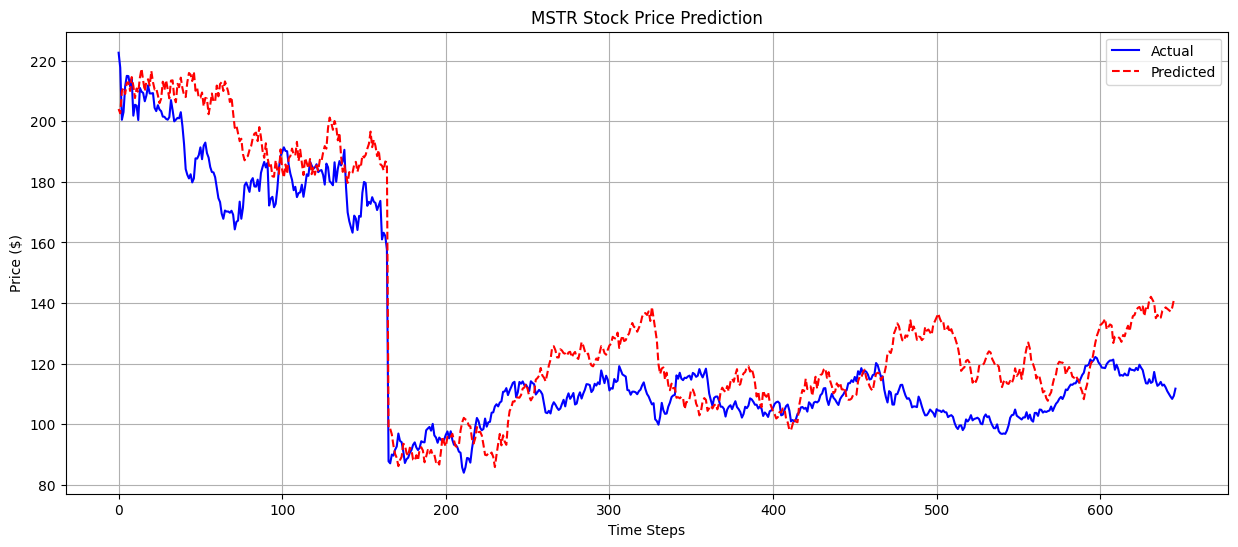


Analyzing DIS...

Evaluation Metrics for DIS:
MSE: 851.5653
RMSE: 29.1816
MAE: 26.9315


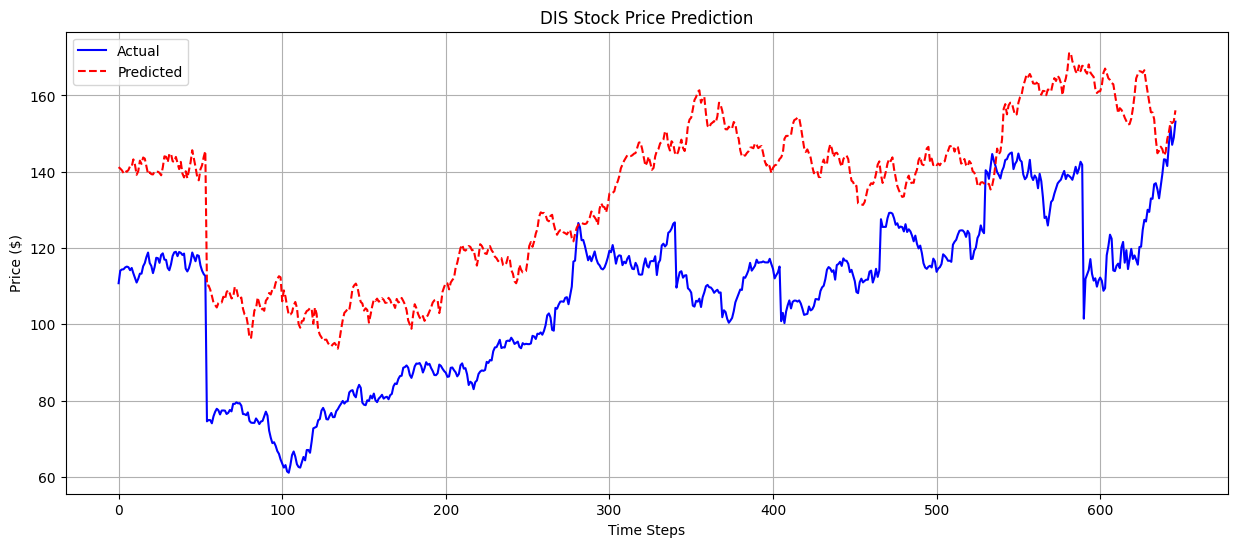


Analyzing BA...

Evaluation Metrics for BA:
MSE: 1446.6921
RMSE: 38.0354
MAE: 25.7753


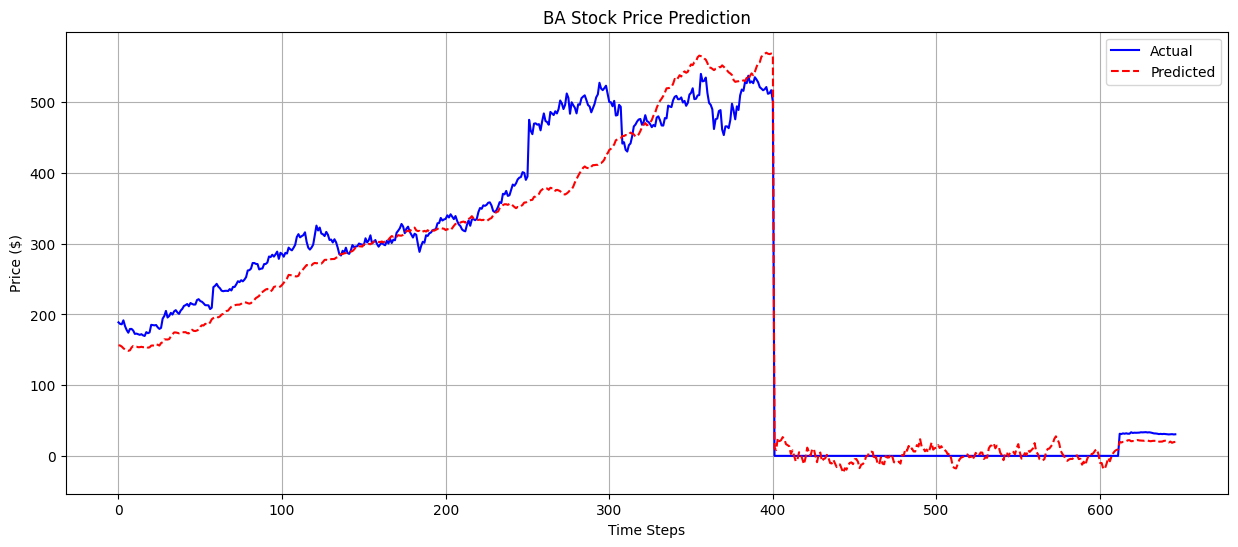


Analyzing XOM...

Evaluation Metrics for XOM:
MSE: 348.4733
RMSE: 18.6674
MAE: 17.5936


In [ ]:
tickers = ['AAPL', 'AMZN', 'GME', 'GOOGL', 'NFLX', 'TSLA', 'MSFT', 'NVDA', 'AMD', 'CRM', 'JPM', 'V', 'MA', 'MSTR', 'DIS', 
           'BA', 'XOM', 'ORCL', 'META', 'BRK', 'HSBC', 'MS', 'PYPL', 'BAC', 'BLK', 'GS']

def split_validation_data(val_X, val_y, stock_lengths):
    """
    Split the combined validation data back into individual stocks.
    
    Args:
        val_X: Combined validation features
        val_y: Combined validation targets
        stock_lengths: List of number of validation samples for each stock
    """
    val_X_stocks = []
    val_y_stocks = []
    
    start_idx = 0
    for length in stock_lengths:
        val_X_stocks.append(val_X[start_idx:start_idx + length])
        val_y_stocks.append(val_y[start_idx:start_idx + length])
        start_idx += length
        
    return val_X_stocks, val_y_stocks

def inverse_transform_price(scaled_data, scaler):
    """
    Convert scaled prices back to actual prices
    """
    # Create a dummy array with zeros for all features
    dummy = np.zeros((len(scaled_data), scaler.scale_.shape[0]))
    # Put the scaled prices in the correct column (-1 is close price next day)
    dummy[:, -1] = scaled_data
    # Inverse transform
    inverse_transformed = scaler.inverse_transform(dummy)
    # Return only the close price column
    return inverse_transformed[:, -1]

def evaluate_predictions(y_true, y_pred, ticker, scaler):
    """
    Calculate and print evaluation metrics for the predictions
    """
    # Convert scaled values back to actual prices
    y_true_actual = inverse_transform_price(y_true, scaler)
    y_pred_actual = inverse_transform_price(y_pred, scaler)
    
    # Calculate metrics on actual prices
    mse = mean_squared_error(y_true_actual, y_pred_actual)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true_actual, y_pred_actual)
    
    print(f"\nEvaluation Metrics for {ticker}:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    
    return mse, rmse, mae

def plot_predictions(actual_values, predicted_values, ticker, scaler):
    """
    Plot actual vs predicted values in actual prices
    """
    plt.figure(figsize=(15, 6))
    
    # Convert to actual prices
    actual_prices = inverse_transform_price(actual_values, scaler)
    predicted_prices = inverse_transform_price(predicted_values, scaler)
    
    # Create time axis for plotting
    time_steps = range(len(actual_prices))
    
    # Plot
    plt.plot(time_steps, actual_prices, label='Actual', color='blue')
    plt.plot(time_steps, predicted_prices, label='Predicted', color='red', linestyle='--')
    
    plt.title(f'{ticker} Stock Price Prediction')
    plt.xlabel('Time Steps')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Calculate validation set lengths for each stock
def get_stock_val_lengths(values_list, train_split=0.8, n_steps_in=14, n_steps_out=5):
    """
    Calculate the number of validation samples for each stock
    """
    val_lengths = []
    for values in values_list:
        n_train = int(len(values) * train_split)
        val_data = values[n_train:]
        n_sequences = len(val_data) - n_steps_in - n_steps_out + 1
        if n_sequences > 0:
            val_lengths.append(n_sequences)
    return val_lengths

# Calculate validation lengths for each stock
val_lengths = get_stock_val_lengths(values_list)

# Split validation data back into individual stocks
val_X_stocks, val_y_stocks = split_validation_data(val_X, val_y, val_lengths)

# Make predictions for each stock
predictions_dict = {}
metrics_dict = {}

for i, ticker in enumerate(tickers):
    print(f"\nAnalyzing {ticker}...")
    
    # Get predictions for valid set
    val_predictions = model.predict(val_X_stocks[i], verbose=0)
    
    # Store predictions
    predictions_dict[ticker] = {
        'actual': val_y_stocks[i],
        'predicted': val_predictions
    }
    
    # Calculate metrics (using first day predictions)
    mse, rmse, mae = evaluate_predictions(
        val_y_stocks[i][:, 0],  # First day actual
        val_predictions[:, 0],   # First day predictions
        ticker,
        scaler
    )
    
    metrics_dict[ticker] = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae
    }
    
    # Plot predictions (first day)
    plot_predictions(
        val_y_stocks[i][:, 0],    # First day actual
        val_predictions[:, 0],     # First day predictions
        ticker,
        scaler
    )

# Create a summary DataFrame of metrics
metrics_df = pd.DataFrame(metrics_dict).T
print("\nSummary of Metrics for All Stocks:")
print(metrics_df)